In [1]:
# Imports

# Required Libraries
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from doubleml import DoubleMLData, DoubleMLPLR
from linearmodels.panel import PanelOLS
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)

# Define a function for calculating root mean squared error
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Data


In [2]:
# Data import

# Importing the dataset from the csv file
filepath = "https://raw.githubusercontent.com/percw/Norwegian_oil_gas_decarbonization/main/data/output/emissions_and_production/cleaned/fields_prod_emissions_intensities_share_1997_2023.csv"

# Creating a check if import is successful
try:
    data = pd.read_csv(filepath, sep=",")
    print("Data import successful")
except:
    print("Data import failed")

Data import successful


### Rename and clean


In [3]:
# Rename "kgco2e/toe_int_gwp100" to "emission_intensity" and "share_intensity_tco2e/toe_gwp100" to "emission_intensity_distributed"

data = data.rename(
    columns={
        "share_intensity_tco2e/toe_gwp100": "emission_intensity_distributed",
        "kgco2e/toe_int_gwp100": "emission_intensity",
    }
)

# Year is %Y datetime
data["year"] = pd.to_datetime(data["year"], format="%Y")

# Get emission tons
data["yearly_tco2_emissions"] = data["yearly_co2_emissions_1000_tonnes"] * 1000

# Remove nans, inf and -inf
#data = data.replace([np.inf, -np.inf], np.nan).dropna()

### TWFE: Effect of Electrification on Emissions Intensity

#### Overview

This script applies a Two-Way Fixed Effects (TWFE) model to estimate the causal impact of electrification on various environmental and production metrics. It accounts for both entity and time fixed effects, making it suitable for panel data analysis where we control for unobserved heterogeneity across fields and over time.

#### Purpose

The primary goal is to assess the effect of electrification (`electrified`) on a set of dependent variables related to emissions and production metrics, while controlling for other relevant factors.

#### Data Preparation

1. **Data Selection**: The data is filtered to include only necessary columns, such as `field_id`, `year`, `electrified`, the dependent variables, and control variables.
2. **Data Cleaning**: NaN values are removed from the dataset to ensure the integrity of the analysis.
3. **Year Dummies**: Dummy variables are created for each year to account for time fixed effects.
4. **Indexing**: The dataset is indexed by `field_id` and `year` to facilitate panel data analysis.

#### Dependent Variables

The dependent variables of interest are:

- `emission_intensity`
- `emission_intensity_distributed`
- `yearly_tco2e_gwp100`
- `yearly_tco2e_prod_share_emissions`

#### Control Variables

The control variables include:

- `net_oil_eq_prod_yearly_mill_sm3`
- `share_reserve_of_original_reserve`

These controls help account for additional factors that might influence the dependent variables.

#### Model Specification

The TWFE model is specified as follows:

$ Y*{it} = \beta_0 + \beta_1 \cdot Electrified*{it} + \beta*2 \cdot X*{it} + \sum*{j=1}^{J-1} \gamma_j \cdot Year_j + \alpha_i + \epsilon*{it} $

Where:

- $ Y\_{it} $ is the dependent variable for field $ i $ at time $ t $.
- $ Electrified\_{it} $ is the treatment variable indicating whether the field is electrified.
- $ X\_{it} $ is a vector of control variables.
- $ Year_j $ are year dummy variables.
- $ \alpha_i $ are entity fixed effects.
- $ \epsilon\_{it} $ is the error term.

#### Results

The model is run twice for each dependent variable:

1. **Without Controls**: Only the treatment variable and year dummies are included.
2. **With Controls**: The treatment variable, year dummies, and control variables are included.

The results are summarized in terms of the following metrics:

- Coefficient ($\beta_1$)
- Confidence Interval (CI)
- P-value
- Mean of the non-treated group
- Percentage change due to the treatment

#### Critical Assessment

1. **Model Choice**: The TWFE model is suitable for panel data analysis as it accounts for unobserved heterogeneity across entities (fields) and over time (years).
2. **Control Variables**: Including relevant control variables helps mitigate omitted variable bias.
3. **Fixed Effects**: Entity and time fixed effects ensure that the estimates are not biased by time-invariant or entity-invariant factors.
4. **Clustered Standard Errors**: These account for within-entity correlation, providing more reliable inference.
5. **Potential Limitations**:
   - ?


In [4]:
dependent_vars = [
    "emission_intensity",
    "emission_intensity_distributed",
    "yearly_tco2e_gwp100",
    "yearly_tco2e_prod_share_emissions",
]

# Define the control variables
control_vars = [
    "net_oil_eq_prod_yearly_mill_sm3",
    "share_reserve_of_original_reserve",
    #"net_oil_prod_yearly_mill_sm3",    # Removed: P-value increased
    #"net_gas_prod_yearly_bill_sm3",    # Removed: P-value increased
    #"share_peak_prod",                 # Removed: P-value increased
    #"original_recoverable_ngl",        # Removed: Fully absorbed
    #"original_recoverable_oe",         # Removed: Fully absorbed
]

# Step 1: Select only the necessary columns for the analysis
columns_needed = ["field_id", "year", "electrified"] + dependent_vars + control_vars
twfe_data = data[columns_needed].copy()

# Convert the 'year' column to a proper integer year if it contains timestamps
twfe_data["year"] = pd.to_datetime(twfe_data["year"], unit="ns").dt.year

# Ensure the 'year' column is of integer type
twfe_data["year"] = twfe_data["year"].astype(int)

# Step 2: Ensure no NaN values are present in the dependent variables or control variables
twfe_data = twfe_data.dropna(subset=dependent_vars + control_vars)

# Step 3: Create year dummies
year_dummies = pd.get_dummies(twfe_data["year"], prefix="year", drop_first=True)
twfe_data = pd.concat([twfe_data, year_dummies], axis=1)

# Step 4: Set the index to a MultiIndex (field_id, year) for panel data analysis
twfe_data = twfe_data.set_index(["field_id", "year"])


# Step 5: Function to perform Two Way Fixed Effects for a given dependent variable
def twfe_model(dependent_var, data, controls=None):
    year_cols = " + ".join(year_dummies.columns)
    formula = f"{dependent_var} ~ electrified + {year_cols} + EntityEffects"
    if controls:
        control_cols = " + ".join(controls)
        formula = f"{dependent_var} ~ electrified + {control_cols} + {year_cols} + EntityEffects"

    # Fit the Two Way Fixed Effects model
    model = PanelOLS.from_formula(formula, data, drop_absorbed=True).fit(
        cov_type="clustered", cluster_entity=True
    )

    return model


# Perform Two Way Fixed Effects model for each dependent variable without controls
results_no_controls = {}
for var in dependent_vars:
    model = twfe_model(var, twfe_data)
    if model is not None:
        non_treated_mean = twfe_data.loc[twfe_data["electrified"] == 0, var].mean()
        treatment_coefficient = model.params["electrified"]
        percentage_change = (treatment_coefficient / non_treated_mean) * 100

        results_no_controls[var] = {
            "model": model,
            "summary": model.summary,
            "coef": treatment_coefficient,
            "conf_int_lower": model.conf_int().loc["electrified"][0],
            "conf_int_upper": model.conf_int().loc["electrified"][1],
            "p_value": model.pvalues["electrified"],
            "non_treated_mean": non_treated_mean,
            "percentage_change": percentage_change,
        }

# Perform Two Way Fixed Effects model for each dependent variable with controls
results_with_controls = {}
for var in dependent_vars:
    model = twfe_model(var, twfe_data, controls=control_vars)
    if model is not None:
        non_treated_mean = twfe_data.loc[twfe_data["electrified"] == 0, var].mean()
        treatment_coefficient = model.params["electrified"]
        percentage_change = (treatment_coefficient / non_treated_mean) * 100

        results_with_controls[var] = {
            "model": model,
            "summary": model.summary,
            "coef": treatment_coefficient,
            "conf_int_lower": model.conf_int().loc["electrified"][0],
            "conf_int_upper": model.conf_int().loc["electrified"][1],
            "p_value": model.pvalues["electrified"],
            "non_treated_mean": non_treated_mean,
            "percentage_change": percentage_change,
        }

# Create summary tables for actual treatment effects
summary_table_no_controls = pd.DataFrame(results_no_controls).T
summary_table_no_controls = summary_table_no_controls[
    [
        "coef",
        "conf_int_lower",
        "conf_int_upper",
        "p_value",
        "non_treated_mean",
        "percentage_change",
    ]
]
summary_table_no_controls.columns = [
    "Coefficient",
    "CI Lower",
    "CI Upper",
    "P-value",
    "Non-treated Mean",
    "Percentage Change",
]

summary_table_with_controls = pd.DataFrame(results_with_controls).T
summary_table_with_controls = summary_table_with_controls[
    [
        "coef",
        "conf_int_lower",
        "conf_int_upper",
        "p_value",
        "non_treated_mean",
        "percentage_change",
    ]
]
summary_table_with_controls.columns = [
    "Coefficient",
    "CI Lower",
    "CI Upper",
    "P-value",
    "Non-treated Mean",
    "Percentage Change",
]

# Create a combined summary table
combined_summary = summary_table_no_controls.copy()
combined_summary["Coef (with controls)"] = summary_table_with_controls["Coefficient"]
combined_summary["CI Lower (with controls)"] = summary_table_with_controls["CI Lower"]
combined_summary["CI Upper (with controls)"] = summary_table_with_controls["CI Upper"]
combined_summary["P-value (with controls)"] = summary_table_with_controls["P-value"]
combined_summary["Percentage Change (with controls)"] = summary_table_with_controls[
    "Percentage Change"
]

print("\n\nComparison of TWFE Model Results without and with Controls:")
display(combined_summary)



Comparison of TWFE Model Results without and with Controls:


,Coefficient,CI Lower,CI Upper,P-value,Non-treated Mean,Percentage Change,Coef (with controls),CI Lower (with controls),CI Upper (with controls),P-value (with controls),Percentage Change (with controls)
emission_intensity,277.327391,-487.021438,1041.67622,0.476631,248.182898,111.743151,232.168019,-403.744507,868.080544,0.473882,93.547147
emission_intensity_distributed,-75.000273,-140.15967,-9.840875,0.024117,216.136113,-34.700482,-86.375462,-138.390513,-34.360412,0.001158,-39.963457
yearly_tco2e_gwp100,-176229.167329,-308263.28911,-44195.045548,0.008948,550447.046083,-32.015644,-154092.266384,-291669.72824,-16514.804529,0.028186,-27.994022
yearly_tco2e_prod_share_emissions,-190524.7641,-370216.390374,-10833.137826,0.037721,516962.247477,-36.854677,-140656.393761,-239913.267432,-41399.52009,0.005525,-27.208253


#### Summary table for distributed emission intensity


In [5]:
# Get the summary for emission_intensity_distributed
results_with_controls["emission_intensity_distributed"]["summary"]

Dep. Variable:,emission_intensity_distributed,R-squared:,0.1609
Estimator:,PanelOLS,R-squared (Between):,0.3090
No. Observations:,1093,R-squared (Within):,0.1609
Date:,"Wed, Jul 24 2024",R-squared (Overall):,0.2255
Time:,19:01:09,Log-likelihood,-6795.1
Cov. Estimator:,Clustered,,
,,F-statistic:,6.5144
Entities:,79,P-value,0.0000
Avg Obs:,13.835,Distribution:,"F(29,985)"
Min Obs:,1.0000,,
Max Obs:,27.000,F-statistic (robust):,5.0193


### Double Machine Learning (DML)


### DML 1: Remaining Reserve and Emission Intensity

#### Overview

This model applies Double Machine Learning (DML) techniques to estimate the causal effect of a treatment variable on an outcome variable. It aims to mitigate biases typically associated with high-dimensional data by combining advanced machine learning algorithms with traditional regression approaches.

#### Purpose

The goal is to understand the impact of the share of remaining reserves (`share_reserve_of_original_reserve`) on emission intensity (`emission_intensity_distributed`), while controlling for various other factors related to oil and gas fields.

#### Data Preparation

1. **Data Filtering**: Fields with negative `share_reserve_of_original_reserve` are removed to maintain data validity.
2. **Dummy Variables**: Categorical variables such as `operator` are converted into dummy variables to facilitate their inclusion in the model.
3. **Treatment Variable**: The treatment variable is `share_reserve_of_original_reserve`.
4. **Control Variables**: These include investments, electrification status, and various facility and well attributes.

#### Model Components

1. **Outcome (Y)**: `emission_intensity_distributed`
2. **Treatment (D)**: `share_reserve_of_original_reserve`
3. **Control Variables (X)**: A set of variables representing investments, electrification status, facilities, and well attributes.

#### Double Machine Learning (DML) Model

The DML model decomposes the estimation process into two main parts:

1. **Model for Outcome (ml_g)**: This uses a Gradient Boosting Regressor to predict the outcome variable based on the treatment and control variables.
2. **Model for Treatment (ml_m)**: This uses an XGBoost Regressor to predict the treatment variable based on the control variables.

These models are chosen due to their effectiveness in handling non-linear relationships and high-dimensional data:

- **Gradient Boosting Regressor**: Captures complex patterns in the outcome variable by iteratively improving the model.
- **XGBoost Regressor**: Known for its high performance and efficiency, especially with large datasets and intricate interactions between variables.

#### Mathematical Formulation

The DML model estimates the following relationship:

$ Y = f(D, X) + \epsilon $

Where:

- $ Y $ is the outcome variable (`emission_intensity_distributed`).
- $ D $ is the treatment variable (`share_reserve_of_original_reserve`).
- $ X $ is a vector of control variables.
- $ \epsilon $ is the error term.

The model uses machine learning algorithms to flexibly estimate the function $ f $, isolating the effect of $ D $ on $ Y $.

#### Quadratic Fit for Visualization

To visualize the relationship between the treatment variable and the outcome, a quadratic regression is used:

$ Y = aX^2 + bX + c $

Where:

- $ Y $ is `emission_intensity_distributed`.
- $ X $ is `share_reserve_of_original_reserve`.
- $ a $, $ b $, and $ c $ are the coefficients obtained from fitting the quadratic model.

The equation is fitted to the data and plotted, showing the trend of how emission intensity changes with the share of remaining reserves.


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Comparison of DML Model Results for Different Outcomes: 
(Treatment: share_reserve_of_original_reserve)


,Coefficient,P-Value,Standard Error,T-Statistic
emission_intensity_distributed,-0.829475,0.006077,0.302333,-2.743582


The quadratic equation is: y = 0.0265x^2 + -3.9068x + 306.2827


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


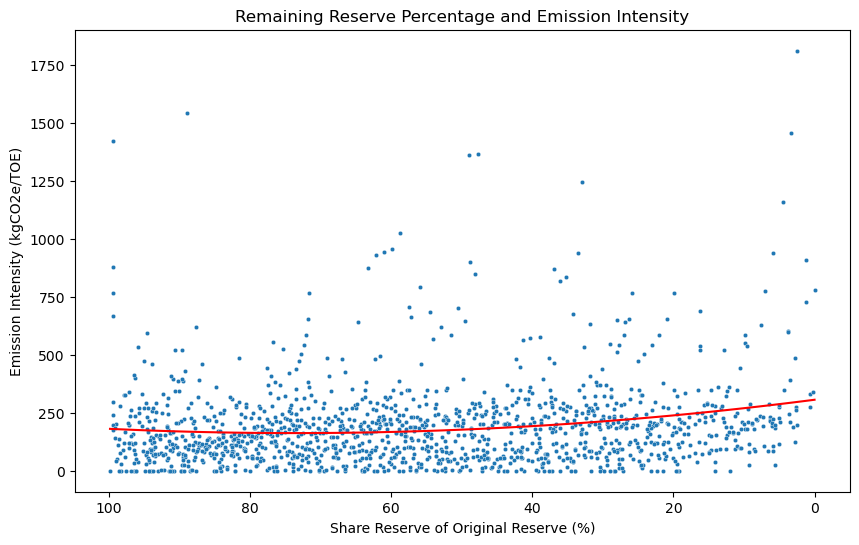

In [100]:
# Set random seeds for reproducibility
random_seed = 42

# Copy the data for DML
data_dml_1 = data.copy()

# Remove fields with negative share_reserve_of_original_reserve
data_dml_1 = data_dml_1[data_dml_1["share_reserve_of_original_reserve"] >= 0]

# Generate the required variables
data_dml_1["processing_field_bin"] = (data_dml_1["processing_field"] == data_dml_1["field"]).astype(float)

# Create dummy variables for operator
field_owner_dummies = pd.get_dummies(data_dml_1["operator"], prefix="operator")
data_dml_1 = pd.concat([data_dml_1, field_owner_dummies], axis=1)

# Define the list of outcomes
outcomes = ["emission_intensity_distributed"]

# Define the treatment and control variables
D = "share_reserve_of_original_reserve"
X = ["investments_mill_nok", "electrified"] + \
    [col for col in data_dml_1.columns if col.startswith("facilities")] + \
    [col for col in data_dml_1.columns if col.startswith("subsea_facilites")] + \
    [col for col in data_dml_1.columns if col.startswith("surface_")] + \
    [col for col in data_dml_1.columns if col.startswith("facility_kind")] + \
    [col for col in data_dml_1.columns if col.startswith("well_status")] + \
    [col for col in data_dml_1.columns if col.startswith("well_purpose")]

# Initialize a dictionary to store the summary statistics
dml_summary_stats = {}

# Iterate over the list of outcomes
for Y in outcomes:
    # Drop rows with NaN values in the relevant columns
    data_dml_1_clean = data_dml_1.dropna(subset=[Y, D] + X)
    
    # Initialize DoubleMLData object
    dml_data = DoubleMLData(data_dml_1_clean, Y, D, X)
    
    # Initialize DoubleMLPLR model with different models
    dml_plr = DoubleMLPLR(
        dml_data,
        ml_g=GradientBoostingRegressor(random_state=random_seed),
        ml_m=XGBRegressor(random_state=random_seed),
        ml_l=LinearRegression()
    )
    
    # Fit the model
    dml_plr.fit()
    
    # Extract the results
    coef = dml_plr.coef
    se = dml_plr.se
    t_stat = dml_plr.t_stat
    p_val = dml_plr.pval
    
    # Store the results in the dictionary
    dml_summary_stats[Y] = {
        "Coefficient": coef[0],
        "Standard Error": se[0],
        "T-Statistic": t_stat[0],
        "P-Value": p_val[0]
    }

# Convert the summary statistics dictionary to a DataFrame
dml_1_summary_df = pd.DataFrame(dml_summary_stats).T

# Display the summary DataFrame
print(f"Comparison of DML Model Results for Different Outcomes: \n(Treatment: {D})")
display(dml_1_summary_df)

# Scatter plot with quadratic fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_dml_1["share_reserve_of_original_reserve"],
    y=data_dml_1["emission_intensity_distributed"],
    s=10  # Marker size
)

# Fit a quadratic polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_1[["share_reserve_of_original_reserve"]])
model = LinearRegression()
model.fit(X_poly, data_dml_1["emission_intensity_distributed"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

# Generate points for the fitted quadratic line
x_range = np.linspace(data_dml_1["share_reserve_of_original_reserve"].min(), data_dml_1["share_reserve_of_original_reserve"].max(), 100)
y_fit = model.predict(poly.transform(x_range.reshape(-1, 1)))

# Plot the fitted quadratic line
plt.plot(x_range, y_fit, color='red')

# Print the quadratic equation
print(f"The quadratic equation is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}")

plt.xlabel("Share Reserve of Original Reserve (%)")
plt.ylabel("Emission Intensity (kgCO2e/TOE)")
plt.title("Remaining Reserve Percentage and Emission Intensity")
plt.gca().invert_xaxis()
plt.show()

### DML 2: Share of Peak Production and Emission Intensity


#### Overview

This script applies a Double Machine Learning (DML) approach to estimate the causal impact of the share of peak production (`share_peak_prod`) on emission intensity (`emission_intensity_distributed`). The DML method combines machine learning algorithms to control for confounding factors and identify causal effects more robustly.

#### Purpose

The primary goal is to assess the effect of the share of peak production on emission intensity, while controlling for various other factors that might influence the outcome. This approach helps mitigate biases that might arise from omitted variables and endogeneity.

#### Data Preparation

1. **Data Selection**: The data is filtered to include only fields with non-negative `share_peak_prod` values.
2. **Data Cleaning**: Necessary dummy variables are created for categorical variables like `operator`.
3. **Variable Generation**: The `processing_field_bin` variable is generated to indicate whether a field is the processing field.

#### Dependent Variable

The dependent variable of interest is:

- `emission_intensity_distributed`

#### Treatment and Control Variables

- **Treatment Variable**: `share_peak_prod`
- **Control Variables**:
  - `investments_mill_nok`
  - `electrified`
  - Dummy variables for facilities, subsea facilities, surface facilities, facility kind, well status, and well purpose.

#### Model Specification

The DML model is specified using a combination of machine learning algorithms:

- **Outcome Model (ml_g)**: Gradient Boosting Regressor
- **Treatment Model (ml_m)**: XGBoost Regressor
- **Linear Model (ml_l)**: Linear Regression

The DML model combines these to control for confounders and estimate the causal effect of the treatment on the outcome.

#### Results

The results of the DML model are summarized in terms of:

- Coefficient (β)
- Standard Error (SE)
- T-Statistic
- P-Value

#### Potential Limitations:

- Model complexity can lead to overfitting if not properly tuned.
- The results depend on the quality of the control variables and the assumption that they capture all relevant confounders.
- Interpretability of the causal effect might be challenging due to the complexity of the machine learning models.


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Comparison of DML Model Results for Different Outcomes: 
(Treatment: share_peak_prod)


,Coefficient,P-Value,Standard Error,T-Statistic
emission_intensity_distributed,-1.183561,4.561176e-10,0.189871,-6.233503


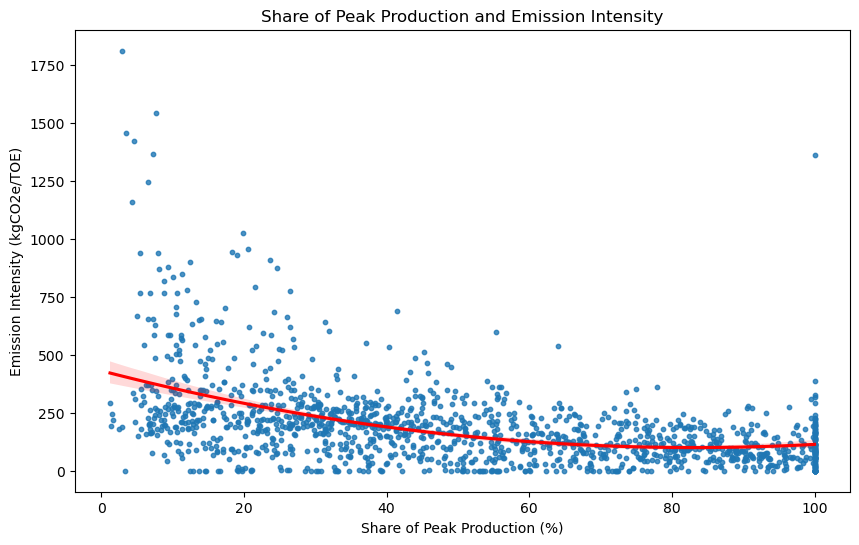

In [103]:
# Set random seeds for reproducibility
random_seed = 42

# Copy the data for DML
data_dml_2 = data.copy()

# Remove fields with negative share_peak_prod
data_dml_2 = data_dml_2[data_dml_2["share_peak_prod"] >= 0]

# Generate the required variables
data_dml_2["processing_field_bin"] = (data_dml_2["processing_field"] == data_dml_2["field"]).astype(float)

# Create dummy variables for operator
field_owner_dummies = pd.get_dummies(data_dml_2["operator"], prefix="operator")
data_dml_2 = pd.concat([data_dml_2, field_owner_dummies], axis=1)

# Define the list of outcomes
outcomes = ["emission_intensity_distributed"]

# Define the treatment and control variables
D = "share_peak_prod"
X = ["investments_mill_nok", "electrified"] + \
    [col for col in data_dml_2.columns if col.startswith("facilities")] + \
    [col for col in data_dml_2.columns if col.startswith("subsea_facilites")] + \
    [col for col in data_dml_2.columns if col.startswith("surface_")] + \
    [col for col in data_dml_2.columns if col.startswith("facility_kind")] + \
    [col for col in data_dml_2.columns if col.startswith("well_status")] + \
    [col for col in data_dml_2.columns if col.startswith("well_purpose")]

# Initialize a dictionary to store the summary statistics
dml_summary_stats = {}

# Iterate over the list of outcomes
for Y in outcomes:
    # Drop rows with NaN values in the relevant columns
    data_dml_2_clean = data_dml_2.dropna(subset=[Y, D] + X)
    
    # Initialize DoubleMLData object
    dml_data = DoubleMLData(data_dml_2_clean, Y, D, X)
    
    # Initialize DoubleMLPLR model with different models
    dml_plr = DoubleMLPLR(
        dml_data,
        ml_g=GradientBoostingRegressor(random_state=random_seed),
        ml_m=XGBRegressor(random_state=random_seed),
        ml_l=LinearRegression()
    )
    
    # Fit the model
    dml_plr.fit()
    
    # Extract the results
    coef = dml_plr.coef
    se = dml_plr.se
    t_stat = dml_plr.t_stat
    p_val = dml_plr.pval
    
    # Store the results in the dictionary
    dml_summary_stats[Y] = {
        "Coefficient": coef[0],
        "Standard Error": se[0],
        "T-Statistic": t_stat[0],
        "P-Value": p_val[0]
    }

# Convert the summary statistics dictionary to a DataFrame
dml_2_summary_df = pd.DataFrame(dml_summary_stats).T

# Display the summary DataFrame
print(f"Comparison of DML Model Results for Different Outcomes: \n(Treatment: {D})")
display(dml_2_summary_df)

# Scatter plot with quadratic fit line
plt.figure(figsize=(10, 6))
sns.regplot(
    x=data_dml_2["share_peak_prod"],
    y=data_dml_2["emission_intensity_distributed"],
    order=2,  # Quadratic fit
    scatter_kws={"s": 10},  # Marker size
    line_kws={"color": "red"}  # Line color
)
plt.xlabel("Share of Peak Production (%)")
plt.ylabel("Emission Intensity (kgCO2e/TOE)")
plt.title("Share of Peak Production and Emission Intensity")
plt.show()

### DML: 3 Estimating Emissions based on Production Volume


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/doubleml/plm/plr.py:122: UserWarning: A learner ml_g has been provided for score = "partialling out" but will be ignored. "A learner ml_g is not required for estimation.
  warnings.warn(('A learner ml_g has been provided for score = "partialling out" but will be ignored. "'


Comparison of DML Model Results for Different Outcomes: 
(Treatment: net_oil_eq_prod_yearly_mill_sm3)


,Coefficient,P-Value,Standard Error,T-Statistic
yearly_tco2e_prod_share_emissions,27783.479867,0.000199,7467.408902,3.720632


The quadratic equation is: y = -1412.4402x^2 + 97909.3884x + 95821.7719


/Users/pcw/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


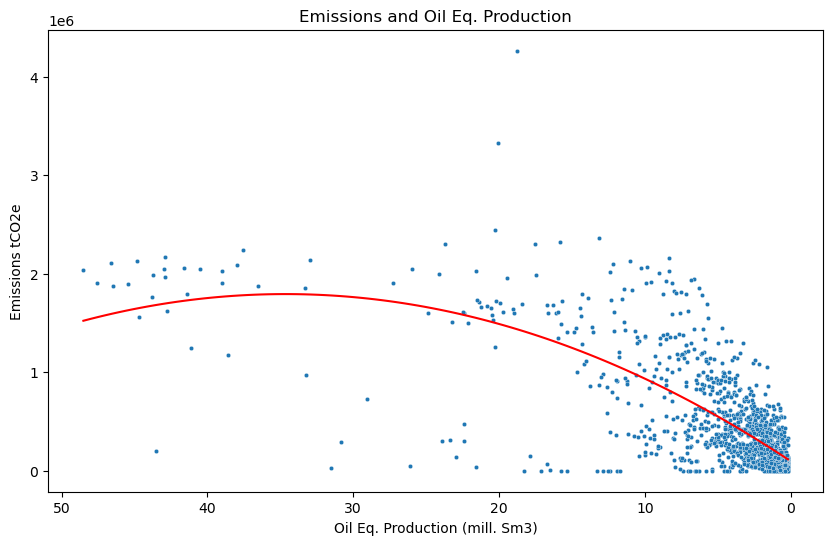

In [131]:
# Set random seeds for reproducibility
random_seed = 42

# Copy the data for DML
data_dml_3 = data.copy()

# Generate the required variables
data_dml_3["processing_field_bin"] = (data_dml_3["processing_field"] == data_dml_3["field"]).astype(float)

# Create dummy variables for operator
field_owner_dummies = pd.get_dummies(data_dml_3["operator"], prefix="operator")
data_dml_3 = pd.concat([data_dml_3, field_owner_dummies], axis=1)

# Define the list of outcomes
outcomes = ["yearly_tco2e_prod_share_emissions"]

# Define the treatment and control variables
D = "net_oil_eq_prod_yearly_mill_sm3"
X = ["investments_mill_nok", "electrified", "future_investments_mill_nok"] + \
    [col for col in data_dml_3.columns if col.startswith("facilities")] + \
    [col for col in data_dml_3.columns if col.startswith("subsea_facilites")] + \
    [col for col in data_dml_3.columns if col.startswith("surface_")] + \
    [col for col in data_dml_3.columns if col.startswith("facility_kind")] + \
    [col for col in data_dml_3.columns if col.startswith("well_status")] + \
    [col for col in data_dml_3.columns if col.startswith("well_purpose")]

# Initialize a dictionary to store the summary statistics
dml_summary_stats = {}

# Iterate over the list of outcomes
for Y in outcomes:
    # Drop rows with NaN values in the relevant columns
    data_dml_3_clean = data_dml_3.dropna(subset=[Y, D] + X)
    
    # Initialize DoubleMLData object
    dml_data = DoubleMLData(data_dml_3_clean, Y, D, X)
    
    # Initialize DoubleMLPLR model with different models
    dml_plr = DoubleMLPLR(
        dml_data,
        ml_g=GradientBoostingRegressor(random_state=random_seed),
        ml_m=XGBRegressor(random_state=random_seed),
        ml_l=LinearRegression()
    )
    
    # Fit the model
    dml_plr.fit()
    
    # Extract the results
    coef = dml_plr.coef
    se = dml_plr.se
    t_stat = dml_plr.t_stat
    p_val = dml_plr.pval
    
    # Store the results in the dictionary
    dml_summary_stats[Y] = {
        "Coefficient": coef[0],
        "Standard Error": se[0],
        "T-Statistic": t_stat[0],
        "P-Value": p_val[0]
    }

# Convert the summary statistics dictionary to a DataFrame
dml_1_summary_df = pd.DataFrame(dml_summary_stats).T

# Display the summary DataFrame
print(f"Comparison of DML Model Results for Different Outcomes: \n(Treatment: {D})")
display(dml_1_summary_df)

# Scatter plot with quadratic fit line
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_dml_3["net_oil_eq_prod_yearly_mill_sm3"],
    y=data_dml_3["yearly_tco2e_prod_share_emissions"],
    s=10  # Marker size
)

# Fit a quadratic polynomial regression model
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(data_dml_3[["net_oil_eq_prod_yearly_mill_sm3"]])
model = LinearRegression()
model.fit(X_poly, data_dml_3["yearly_tco2e_prod_share_emissions"])

# Extract the coefficients
a, b, c = model.coef_[2], model.coef_[1], model.intercept_

dml_3_equation = {
    "a": a,
    "b": b,
    "c": c
}

# Generate points for the fitted quadratic line
x_range = np.linspace(data_dml_3["net_oil_eq_prod_yearly_mill_sm3"].min(), data_dml_3["net_oil_eq_prod_yearly_mill_sm3"].max(), 100)
y_fit = model.predict(poly.transform(x_range.reshape(-1, 1)))

# Plot the fitted quadratic line
plt.plot(x_range, y_fit, color='red')

# Print the quadratic equation
print(f"The quadratic equation is: y = {a:.4f}x^2 + {b:.4f}x + {c:.4f}")

plt.xlabel("Oil Eq. Production (mill. Sm3)")
plt.ylabel("Emissions tCO2e")
plt.title("Emissions and Oil Eq. Production")
plt.gca().invert_xaxis()
plt.show()